# Overview

This notebook demonstrates how to learn a neural network measurement model from data. Instead of using analytical measurement equations, we train an ANN to predict sensor outputs (optic flow, accelerations, angular measurements) from states and controls.

**Topics covered:**

1. **Install and Import Packages** - Setup the computational environment
2. **Load and Prepare Training Data** - Import trajectory data with sensor measurements
3. **Data Augmentation with Delay Embedding** - Create time-windowed inputs
4. **Neural Network Training** - Build and train the measurement model
5. **Model Evaluation** - Visualize performance and validate predictions

**Key learning objectives:**
- Understand how to learn measurement models from data
- Build neural networks that map states to sensor outputs
- Train models that predict continuous sensor measurements
- Evaluate measurement model accuracy on test trajectories
- Compare learned models with analytical measurement equations

**Applications:**
- State estimation with learned measurement models
- Sensor fusion with complex, nonlinear sensors
- Calibration and compensation for sensor nonlinearities
- Virtual sensor synthesis (predicting unavailable measurements)

**Comparison with dynamics model (Lesson 13.A):**
- **Dynamics model:** Predicts $\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, \mathbf{u})$ (state derivatives)
- **Measurement model:** Predicts $\mathbf{y} = \mathbf{h}(\mathbf{x}, \mathbf{u})$ (sensor outputs)

# 1.&nbsp;Install and Import Packages

## Install utility

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
try:
    import nonlinear_estimation_utilities
    print('Package ' + 'nonlinear_estimation_utilities' + ' is already installed.')
    nonlinear_estimation_utilities.check_for_updates()
except:
    !pip install -qq git+https://github.com/florisvb/Nonlinear_and_Data_Driven_Estimation && echo "✓ nonlinear_estimation_utilities installed"
    import nonlinear_estimation_utilities
    nonlinear_estimation_utilities.check_for_updates()

Package nonlinear_estimation_utilities is already installed.
✓ You have the latest version (0.0.35)


## Install requirements

In [3]:
nonlinear_estimation_utilities.install_and_download_requirements.install_planar_drone_requirements()
nonlinear_estimation_utilities.install_and_download_requirements.install_neural_network_requirements()

Already installed: casadi
Already installed: do_mpc
Already installed: git+https://github.com/vanbreugel-lab/pybounds
Already installed: pynumdiff


2025-12-01 17:02:32.656370: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-01 17:02:32.730563: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 17:02:33.769751: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Already installed: tensorflow
Already installed: keras
Attempting to pip install: keras-visualizer
✓ pynumdiff 0.1.4.dev258+g5d960720f meets requirement >=0.1.4
Already installed: pynumdiff


## Install modules

In [4]:
nonlinear_estimation_utilities.load_planar_drone_modules()
nonlinear_estimation_utilities.load_neural_network_modules()

## Import modules

In [6]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [7]:
import keras
import tensorflow as tf

In [8]:
from nonlinear_estimation_utilities import plot_utility
from nonlinear_estimation_utilities import planar_drone
from nonlinear_estimation_utilities import generate_training_data_utility
from nonlinear_estimation_utilities import terrain_and_optic_flow_utility
from nonlinear_estimation_utilities import keras_ann_utility
from nonlinear_estimation_utilities import keras_advanced_utility

from nonlinear_estimation_utilities.plot_utility import plot_tme

# 2.&nbsp;Load and Prepare Training Data

We'll download trajectory data that includes both state information and corresponding sensor measurements. The data preprocessing follows the same pipeline as Lesson 12.A, including cleaning and noise addition.

**Key difference from dynamics model:** Here we use sensor measurements as outputs rather than computing state derivatives.

## Download and prepare trajectory data

Download the pre-generated trajectory dataset, load trajectories, clean invalid data, and add measurement noise.

In [9]:
generate_training_data_utility.download_data('planar_drone_trajectories.zip')
traj_list = generate_training_data_utility.load_trajectory_data('planar_drone_trajectories')
traj_list = generate_training_data_utility.clean_trajectory_data(traj_list)
traj_list = generate_training_data_utility.add_noise_to_trajectory_data(traj_list, 0.02)

Fetching from: https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Data/planar_drone_trajectories.zip
Successfully downloaded planar_drone_trajectories.zip (29316396 bytes)
unzipping...
Number of trajectories: 
3001
Number of good trajectories: 
2924


# 3.&nbsp;Data Augmentation with Delay Embedding

We augment the input data with time-delayed states and controls. For measurement models, delay embedding can help capture:
- **Sensor dynamics:** Many sensors have internal dynamics or filtering
- **Time-varying biases:** Sensor characteristics that drift slowly
- **Motion-dependent effects:** Measurements that depend on velocity or acceleration history

The neural network learns to map from augmented state/control history to current sensor outputs:

$$
\mathbf{y}_t = \mathbf{h}(\mathbf{x}_t, \mathbf{x}_{t-1}, \mathbf{u}_t, \mathbf{u}_{t-1})
$$

## Define state, control, and sensor variables

Specify the input variables (states and controls) and output variables (sensor measurements).

In [10]:
state_names =  ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot'] 
control_names = ['j1', 'j2']
output_names = ['sensor_optic_flow', 'sensor_theta', 'sensor_theta_dot', 'sensor_accel_x', 'sensor_accel_z']

## Define time offsets for delay embedding

Specify which time steps to include in the augmented inputs. Using `[0, -1]` includes both current and previous time steps.

In [11]:
state_offsets = [0, -1]
control_offsets = [0, -1]
output_offsets = [0]

## Build augmented dataframes

Create augmented trajectories where each row contains time-windowed states, controls, and corresponding sensor measurements.

In [12]:
traj_augment_list = []
for traj in traj_list:
    traj_augment = keras_ann_utility.collect_offset_rows(traj, states=state_names, controls=control_names, outputs=output_names, 
                        state_offsets=state_offsets, control_offsets=control_offsets, output_offsets=output_offsets)
    
    traj_augment_list.append(traj_augment)

traj_augment_all = pd.concat(traj_augment_list, ignore_index=True)

np.round(traj_augment_all, 4)

,theta_offset_0,theta_dot_offset_0,x_offset_0,x_dot_offset_0,z_offset_0,z_dot_offset_0,theta_offset_-1,theta_dot_offset_-1,x_offset_-1,x_dot_offset_-1,...,z_dot_offset_-1,j1_offset_0,j2_offset_0,j1_offset_-1,j2_offset_-1,sensor_optic_flow_offset_0,sensor_theta_offset_0,sensor_theta_dot_offset_0,sensor_accel_x_offset_0,sensor_accel_z_offset_0
0,-0.7740,-0.0391,-9.9974,1.7836,9.6739,-5.1722,-0.5012,-5.6704,-10.1041,1.1340,...,-5.0022,-0.0157,19.5849,2.2709,9.9279,0.1443,-0.7937,0.0084,-49.8682,-2.8005
1,-0.7837,0.0089,-9.7132,3.1571,9.1513,-4.8179,-0.7740,-0.0391,-9.9974,1.7836,...,-5.1722,0.0025,27.3760,-0.0157,19.5849,0.3702,-0.7675,-0.0033,13.8049,4.0086
2,-0.7988,0.0245,-9.3224,5.0702,8.7093,-3.8616,-0.7837,0.0089,-9.7132,3.1571,...,-4.8179,-0.0020,32.8950,0.0025,27.3760,0.5727,-0.7911,0.0004,19.3562,9.5484
3,-0.8070,0.0069,-8.7041,7.3862,8.4394,-2.5006,-0.7988,0.0245,-9.3224,5.0702,...,-3.8616,-0.0459,35.7129,-0.0020,32.8950,0.8712,-0.8045,-0.0308,23.2316,13.4588
4,-0.7840,-0.0221,-7.8431,9.9169,8.2075,-0.9382,-0.8070,0.0069,-8.7041,7.3862,...,-2.5006,1.1189,36.1054,-0.0459,35.7129,1.2001,-0.7794,0.0054,25.2752,15.4224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260231,0.0856,-0.0133,0.6724,0.7578,2.1346,-1.9238,0.0542,0.3587,0.6215,0.8228,...,-2.5040,-0.0176,17.0044,-0.1520,15.7585,0.3520,0.0966,-0.0671,-1.2306,7.1525
260232,0.0717,-0.1128,0.7495,0.5749,1.9739,-1.2456,0.0856,-0.0133,0.6724,0.7578,...,-1.9238,-0.0343,17.6896,-0.0176,17.0044,0.3285,0.0805,-0.0992,-1.1112,7.8512
260233,0.0566,-0.2020,0.7947,0.5021,1.9042,-0.4100,0.0717,-0.1128,0.7495,0.5749,...,-1.2456,-0.0567,17.7788,-0.0343,17.6896,0.2448,0.0486,-0.2226,-0.8510,7.9783
260234,0.0402,-0.4785,0.8496,0.4762,1.8875,0.3672,0.0566,-0.2020,0.7947,0.5021,...,-0.4100,-0.0779,17.2749,-0.0567,17.7788,0.2424,0.0306,-0.4204,-0.2664,7.4941


In [13]:
n_state = len(state_names)
n_control = len(control_names)
n_output = len(output_names)
delay_embedding = len(state_offsets)

print('States:', n_state)
print('Controls:', n_control)
print('Outputs:', n_output)
print('Delay embedding:', delay_embedding)

States: 6
Controls: 2
Outputs: 5
Delay embedding: 2


## Separate inputs and outputs

Split the augmented data into:
- **State inputs** (core and auxiliary/delayed)
- **Control inputs** (core and auxiliary/delayed)  
- **Sensor outputs** (measurements to predict)

In [14]:
# Augmented state data
X = traj_augment_all.iloc[:, 0:n_state*delay_embedding]
X

,theta_offset_0,theta_dot_offset_0,x_offset_0,x_dot_offset_0,z_offset_0,z_dot_offset_0,theta_offset_-1,theta_dot_offset_-1,x_offset_-1,x_dot_offset_-1,z_offset_-1,z_dot_offset_-1
0,-0.773981,-0.039066,-9.997418,1.783556,9.673862,-5.172229,-0.501238,-5.670445,-10.104143,1.133966,10.209705,-5.002241
1,-0.783705,0.008906,-9.713168,3.157087,9.151264,-4.817869,-0.773981,-0.039066,-9.997418,1.783556,9.673862,-5.172229
2,-0.798776,0.024525,-9.322357,5.070159,8.709284,-3.861630,-0.783705,0.008906,-9.713168,3.157087,9.151264,-4.817869
3,-0.806996,0.006852,-8.704123,7.386234,8.439431,-2.500591,-0.798776,0.024525,-9.322357,5.070159,8.709284,-3.861630
4,-0.784007,-0.022142,-7.843080,9.916940,8.207550,-0.938200,-0.806996,0.006852,-8.704123,7.386234,8.439431,-2.500591
...,...,...,...,...,...,...,...,...,...,...,...,...
260231,0.085600,-0.013251,0.672385,0.757753,2.134634,-1.923779,0.054218,0.358678,0.621538,0.822827,2.368574,-2.504037
260232,0.071687,-0.112778,0.749509,0.574940,1.973867,-1.245606,0.085600,-0.013251,0.672385,0.757753,2.134634,-1.923779
260233,0.056650,-0.202012,0.794660,0.502078,1.904179,-0.410009,0.071687,-0.112778,0.749509,0.574940,1.973867,-1.245606
260234,0.040159,-0.478458,0.849561,0.476173,1.887532,0.367182,0.056650,-0.202012,0.794660,0.502078,1.904179,-0.410009


In [15]:
# Augmented control data
U = traj_augment_all.iloc[:, n_state*delay_embedding:n_state*delay_embedding+n_control*delay_embedding]
U

,j1_offset_0,j2_offset_0,j1_offset_-1,j2_offset_-1
0,-0.015713,19.584923,2.270920,9.927886
1,0.002464,27.376012,-0.015713,19.584923
2,-0.001997,32.895027,0.002464,27.376012
3,-0.045862,35.712870,-0.001997,32.895027
4,1.118925,36.105435,-0.045862,35.712870
...,...,...,...,...
260231,-0.017648,17.004369,-0.151963,15.758540
260232,-0.034282,17.689585,-0.017648,17.004369
260233,-0.056691,17.778793,-0.034282,17.689585
260234,-0.077875,17.274901,-0.056691,17.778793


In [16]:
# Output data
Y = traj_augment_all.iloc[:, n_state*delay_embedding+n_control*delay_embedding:]
Y

,sensor_optic_flow_offset_0,sensor_theta_offset_0,sensor_theta_dot_offset_0,sensor_accel_x_offset_0,sensor_accel_z_offset_0
0,0.144290,-0.793735,0.008365,-49.868207,-2.800538
1,0.370204,-0.767538,-0.003316,13.804941,4.008617
2,0.572691,-0.791105,0.000420,19.356163,9.548375
3,0.871177,-0.804531,-0.030788,23.231603,13.458794
4,1.200136,-0.779385,0.005396,25.275243,15.422355
...,...,...,...,...,...
260231,0.351984,0.096596,-0.067122,-1.230636,7.152493
260232,0.328497,0.080547,-0.099173,-1.111184,7.851172
260233,0.244790,0.048613,-0.222613,-0.851008,7.978277
260234,0.242397,0.030634,-0.420384,-0.266412,7.494123


## Combine and organize data

Package the data into a structured format with core inputs (current time) and auxiliary inputs (time-delayed) for the neural network.

In [17]:
# Organize the data so we have the core data, and augmented (delay embedded) data
core_data = np.hstack((X.values[:, 0:n_state], U.values[:, 0:n_control]))
#aux_data = np.hstack((X.values[:, n_state:], U.values[:, n_control:]))
aux_data = core_data**-1
output_data = Y.values

In [18]:
all_data = {'X_core_train': core_data,
        'X_aux_train': aux_data,
        'y_train': output_data}

## Split into training and validation sets

Divide the data into training, validation, and test subsets to evaluate generalization performance.

In [19]:
# split the data
data = keras_advanced_utility.prepare_train_test_split(all_data, test_size=0.2, random_state=42)

Data split complete:
  Training samples: 208188 (80%)
  Test samples: 52048 (20%)
  Core features: 8
  Aux features: 8
  Output dimension: 5


In [20]:
data.keys()

dict_keys(['X_core_train', 'X_core_test', 'X_aux_train', 'X_aux_test', 'y_train', 'y_test'])

# 4.&nbsp;Neural Network Training

We'll build a neural network with the same architecture pattern as the dynamics model:

**Architecture components:**
- **Core input branch:** Processes current state and control
- **Auxiliary input branch:** Processes time-delayed state and control history
- **Combined layers:** Merges both branches to predict sensor outputs
- **Output layer:** Predicts all sensor measurements simultaneously

The network is trained to minimize prediction error of the sensor measurements. Unlike the dynamics model, we don't typically use Jacobian regularization here since measurement models are algebraic (not differential equations).

## Define architecture and train model

Specify the network architecture with separate processing paths for core and auxiliary inputs, then build, compile, and train the model.

In [21]:
# Define model architecture
core_architecture = [
    {'units': 64, 'activation': 'tanh'},
    {'units': 64, 'activation': 'tanh'}
]

aux_architecture = [
    {'units': 64, 'activation': 'tanh'}
]

combined_architecture = [
    {'units': 32, 'activation': 'linear'},
    {'units': output_data.shape[1]}  # Output layer
]

input_architecture = {'core_input_dim': data['X_core_train'].shape[1],
                      'aux_input_dim': data['X_aux_train'].shape[1]}


training_parameters = {'jacobian_weight': 0.1,
                       'sv_weight': 0.01}

In [22]:
# Build model
print("\nBuilding model...")
model, dropout_layer = keras_advanced_utility.build_auxiliary_dropout_model(
    core_input_dim=input_architecture['core_input_dim'],
    aux_input_dim=input_architecture['aux_input_dim'],
    core_architecture=core_architecture,
    aux_architecture=aux_architecture,
    combined_architecture=combined_architecture,
    jacobian_weight=training_parameters['jacobian_weight'],
    sv_weight=training_parameters['sv_weight']
)


Building model...


2025-12-01 17:04:31.771350: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [23]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse', 
    metrics=['mae']
)
model.summary()

Model: "jacobian_regularized_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 core_features (InputLayer)  [(None, 8)]                  0         []                            
                                                                                                  
 aux_features (InputLayer)   [(None, 8)]                  0         []                            
                                                                                                  
 core_dense_0 (Dense)        (None, 64)                   576       ['core_features[0][0]']       
                                                                                                  
 aux_dropout (Dropout)       (None, 8)                    0         ['aux_features[0][0]']        
                                                                         

In [24]:
# Train with curriculum learning
print("\nTraining with curriculum learning...")
history, curriculum_callback, X_core_val, X_aux_val, y_val = keras_advanced_utility.train_with_curriculum(
    model=model,
    dropout_layer=dropout_layer,
    X_core_train=data['X_core_train'],
    X_aux_train=data['X_aux_train'],
    y_train=data['y_train'],
    validation_split=0.2,
    epochs=200,
    batch_size=128,
    initial_dropout=0.5, # start with dropping out 20% of the auxilliary inputs
    final_dropout=0.99,  # end with dropping out 95% of the auxiliary inputs
    warmup_fraction=0.5,
    verbose=1
)


Training with curriculum learning...
Curriculum learning schedule:
  Total epochs: 200
  Warmup epochs: 100 (50% of training)
  Dropout: 0.50 → 0.99
  Final dropout reached at epoch 100
Epoch 1/200
1302/1302 [==============================] - 10s 6ms/step - loss: 10.6966 - mae: 1.6557 - jacobian_smoothness: 1.7732e-05 - sv_loss: 0.0875 - val_loss: 6.9104 - val_mae: 1.1730 - val_jacobian_smoothness: 0.0000e+00 - val_sv_loss: 0.0000e+00 - dropout_rate: 0.5000 - val_mae_with_aux: 1.1730 - val_mae_without_aux: 1.1320
Epoch 2/200
1302/1302 [==============================] - 8s 6ms/step - loss: 5.7719 - mae: 0.9703 - jacobian_smoothness: 1.1505e-04 - sv_loss: 3.1570e-04 - val_loss: 4.9165 - val_mae: 0.8487 - val_jacobian_smoothness: 0.0000e+00 - val_sv_loss: 0.0000e+00 - dropout_rate: 0.5049 - val_mae_with_aux: 0.8487 - val_mae_without_aux: 0.8125
Epoch 3/200
1302/1302 [==============================] - 8s 6ms/step - loss: 4.5318 - mae: 0.7582 - jacobian_smoothness: 2.6051e-04 - sv_loss: 7.


VALIDATION SET PERFORMANCE:
MAE without auxiliary features: 0.2758
MAE with auxiliary features:    0.2774
⚠ Without aux performs 0.60% better

TEST SET PERFORMANCE:
MAE without auxiliary features: 0.2767
MAE with auxiliary features:    0.2782
⚠ Without aux performs 0.54% better

Generating visualizations...


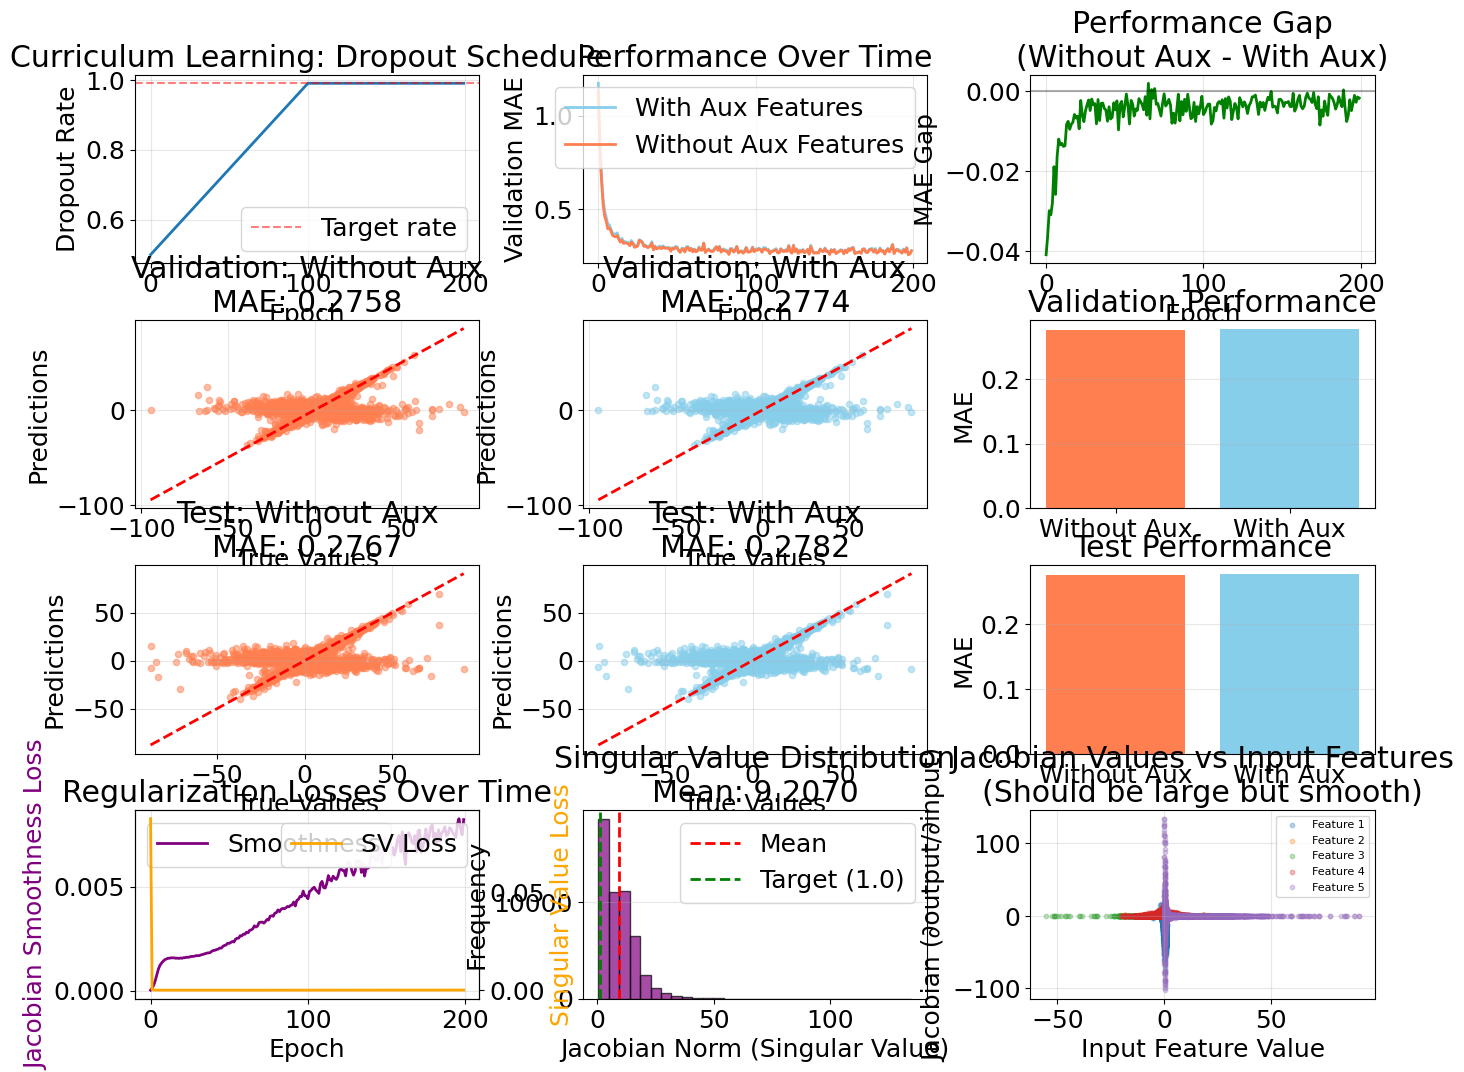


SUMMARY
Final dropout rate: 0.99
Mean Jacobian norm: 2.3714

Training complete! Check 'curriculum_dropout_results.png' for visualizations.


In [25]:
# Evaluate on validation and test sets
val_results = keras_advanced_utility.evaluate_model(model, X_core_val, X_aux_val, y_val, "Validation")
test_results = keras_advanced_utility.evaluate_model(model, data['X_core_test'], data['X_aux_test'], 
                               data['y_test'], "Test")

# Visualize results
print("\nGenerating visualizations...")
keras_advanced_utility.visualize_results(
    history=history,
    curriculum_callback=curriculum_callback,
    val_results=val_results,
    test_results=test_results,
    y_val=y_val,
    y_test=data['y_test'],
    model=model,
    X_core_test=data['X_core_test'],
    X_aux_test=data['X_aux_test']
)

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Final dropout rate: {curriculum_callback.dropout_history[-1]:.2f}")
print(f"Mean Jacobian norm: {np.linalg.norm(np.random.randn(10, 5), axis=1).mean():.4f}")
print("\nTraining complete! Check 'curriculum_dropout_results.png' for visualizations.")

In [26]:
keras_advanced_utility.save_model_complete(
    model=model,
    filepath='smooth_measurements_model',  # No extension needed
    core_architecture=core_architecture,
    aux_architecture=aux_architecture,
    combined_architecture=combined_architecture,
    input_architecture=input_architecture,
    training_parameters=training_parameters
)

Saving weights layer-by-layer for compatibility...
  Saved layer: core_dense_0
  Saved layer: core_dense_1
  Saved layer: aux_dense_0
  Saved layer: combined_dense_0
  Saved layer: combined_dense_1
✓ Saved weights to: smooth_measurements_model.weights.h5
✓ Saved configuration to: smooth_measurements_model.config.json

Model saved successfully!
To load: model, dropout_layer, config = load_model_complete('smooth_measurements_model')


# 5.&nbsp;Model Evaluation

Evaluate the trained measurement model by comparing predicted versus true sensor outputs on validation data. This helps assess whether the learned model can accurately replace analytical measurement equations.

## Check predictions for specific sensors

Compare predicted and true measurements for individual sensors. This helps identify which sensors are well-modeled and which may need architecture improvements.

**Interpretation:**
- Good agreement indicates the model captures the state-to-measurement mapping
- Systematic errors suggest missing features or insufficient model capacity
- Random scatter indicates noise that cannot be predicted from states alone

**For debugging:** If certain sensors show poor prediction accuracy, consider:
- Increasing network capacity (more layers or units)
- Adding more delay-embedded inputs
- Checking if sensor depends on variables not included in inputs
- Verifying data quality and preprocessing

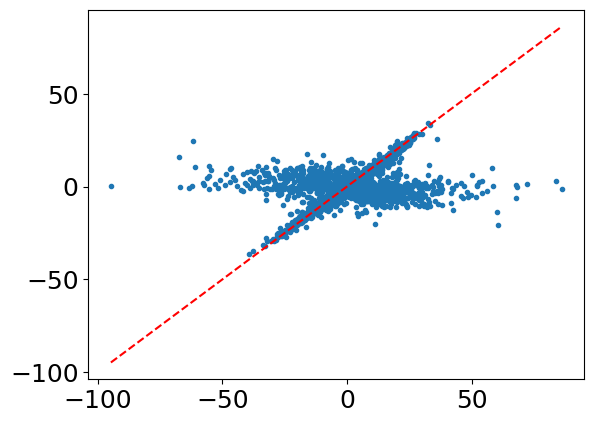

In [34]:
state = 3
plt.plot(y_val[:,state], val_results['predictions_without_aux'][:,state], '.')
l = np.linspace(np.min(y_val[:, state]), np.max(y_val[:,state]))
plt.plot(l, l, '--', color='red')

# 6.&nbsp;Exercises

1. **Compare with analytical model:**
   - Load the analytical measurement equations from the planar drone module
   - Compare predictions from the learned ANN versus analytical equations
   - Quantify prediction error (RMSE, max error) for each sensor
   - Identify scenarios where the ANN performs better or worse

2. **Sensor-specific modeling:**
   - Train separate networks for each sensor type
   - Compare performance with the unified multi-output model
   - Assess computational cost versus accuracy tradeoffs

3. **Architecture exploration:**
   - Try different numbers of hidden layers and units
   - Experiment with different activation functions
   - Compare performance with and without auxiliary delay-embedded inputs
   - Test the effect of dropout on generalization

4. **Temporal depth analysis:**
   - Vary the number of time steps in the delay embedding
   - For which sensors does temporal history improve predictions?
   - Identify sensors that are purely instantaneous versus history-dependent

5. **Integration with state estimation:**
   - Use the learned measurement model in a Kalman filter or particle filter
   - Compare state estimation accuracy with analytical measurement model
   - Assess whether learned model provides better robustness to modeling errors

6. **Missing sensor prediction:**
   - Train the model without certain sensors in the training data
   - Use the model to synthesize "virtual" versions of those sensors
   - Test if the ANN can infer missing measurements from available sensors

7. **Sensor calibration:**
   - Add systematic biases or scale errors to sensors in training data
   - Train the model on biased data
   - Test if the learned model automatically compensates for calibration errors

8. **Transfer to real hardware:**
   - If real sensor data is available, fine-tune the simulation-trained model
   - Assess sim-to-real transfer performance
   - Identify which sensors transfer well versus poorly

9. **Uncertainty quantification:**
   - Train an ensemble of measurement models
   - Use prediction variance to estimate measurement uncertainty
   - Incorporate uncertainty estimates into state estimation algorithms